# Import package modules

In [3]:
from vesicle_picker import helpers, preprocess, generate_masks, postprocess, external_import, external_export, funcs_mrcio
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Import a micrograph from CryoSPARC

In [53]:
# Use the csparc_import module to initialize a cryosparc session
cs = external_import.load_cryosparc("../my_csparc_login.ini")

Connection succeeded to CryoSPARC command_core at http://klug.sickkids.ca:39002
Connection succeeded to CryoSPARC command_vis at http://klug.sickkids.ca:39003
Connection succeeded to CryoSPARC command_rtp at http://klug.sickkids.ca:39005


In [58]:
# Pull micrographs object from the output of a curate job
micrographs = external_import.micrographs_from_csparc(
    cs = cs,
    project_id = "P143", 
    job_id = "J763", 
    job_type = "curate"
)

project = cs.find_project("P143")

In [111]:
# Isolate and download just the first micrograph
micrograph = micrographs[3]
header, image_fullres = project.download_mrc(micrograph["micrograph_blob/path"])

# Isolate the 2D numpy array containing the image
image_fullres = image_fullres[0]

# Import a micrograph from disk

In [5]:
# # Define an import function
# def import_mrc(filename):
#     """Use funcs_mrcio to open a specified .mrc file"""
#     # Read the .mrc file in binary
#     micrograph = open(filename,'rb')
    
#     # Use funcs_mrcio to extract image array and rescale values to lie between [-1, 1]
#     image = funcs_mrcio.irdsec_opened(micrograph,0)
    
#     # Use funcs_mrcio to extract header info
#     header = funcs_mrcio.irdhdr_opened(micrograph)
    
#     # Return the rescaled image and header
#     return image, header

In [6]:
# # Import the example mrc
# image_fullres, header = import_mrc("vesicles.mrc")

# Preprocess micrograph

In [112]:
# Use the preprocess module to get micrograph ready for segmentation
preprocessed_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "bilateral",
                                                           d = 17,
                                                           sigmaColor=71,
                                                           sigmaSpace=71)

(-0.5, 1023.5, 1023.5, -0.5)

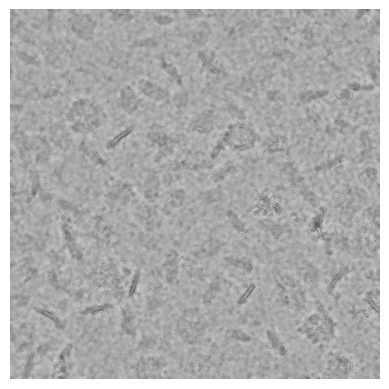

In [113]:
# Display the preprocessed micrograph
plt.imshow(preprocessed_micrograph, cmap="Greys_r")
plt.axis('off')

# Generate masks

In [100]:
# Use the generate_masks module to perform automatic image segmentation

# Initialize the model
model = generate_masks.initialize_model(model_weights_path = "../sam_vit_h_4b8939.pth", device='cuda:0')

In [114]:
# Generate masks with user-optimized parameters
masks = generate_masks.generate_masks(preprocessed_micrograph, model, 
    points_per_side=36,
    points_per_batch=16,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    crop_nms_thresh=0.15,
    min_mask_region_area=100,
    psize=1.5,
    downsample=4)

# Postprocess masks

In [115]:
# Use the postprocess module to compute statistics on the vesicles
postprocessed_masks = postprocess.postprocess_masks(masks, 
                              [postprocess.find_mask_intensity, postprocess.find_contour, postprocess.find_roundness, postprocess.fit_ellipse], 
                              preprocessed_micrograph)

In [1]:
# Filter these vesicles based on min and max values recorded in 'filters.ini'
filtered_masks = postprocess.apply_filters(postprocessed_masks, "filters.ini")

# Use the extract_statistics function to generate Pandas Dataframes of the postprocessed values, for downstream visualizations.
# See `vesicle_diagnostics.ipynb` for more details on how to do this for a collection of micrographs.
unfiltered_dataset, filtered_dataset = postprocess.extract_statistics(postprocessed_masks, "filters.ini")

NameError: name 'postprocess' is not defined

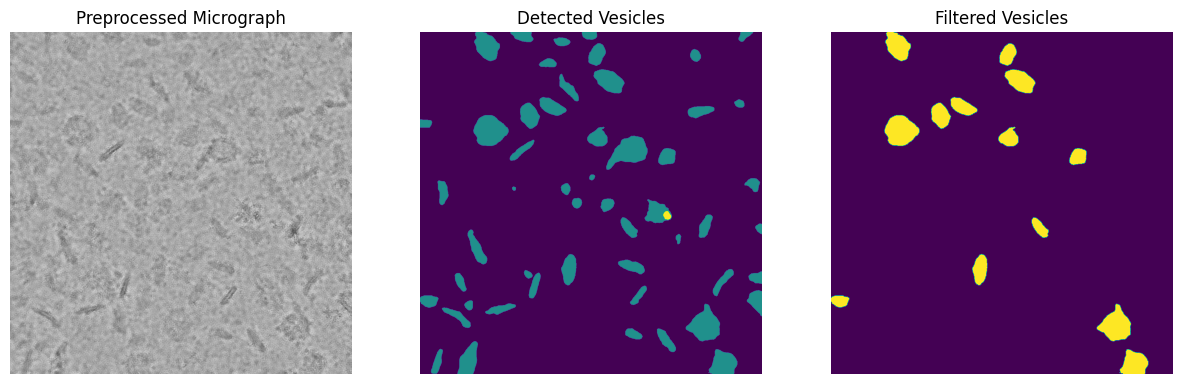

In [117]:
# Create a figure with three subplots arranged in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image in the first subplot
axes[0].imshow(preprocessed_micrograph, cmap="Greys_r")
axes[0].set_title('Preprocessed Micrograph')

# Plot the second image in the second subplot
axes[1].imshow(helpers.sum_masks(masks, 'segmentation'))
axes[1].set_title('Detected Vesicles')

# # Plot the third image in the third subplot
axes[2].imshow(helpers.sum_masks(filtered_masks, 'segmentation'))
axes[2].set_title('Filtered Vesicles')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

In [118]:
# Once you have a set of filters you like, generate the picks
pick_indices = postprocess.generate_picks(filtered_masks, 1.5, 4, 100, mode='edge')

# # Dilate the masks
dilated_masks = postprocess.dilate_masks(filtered_masks, 100, 1.5, 4)
dilated_pick_indices = postprocess.generate_picks(dilated_masks, 1.5, 4, 256, mode='edge')

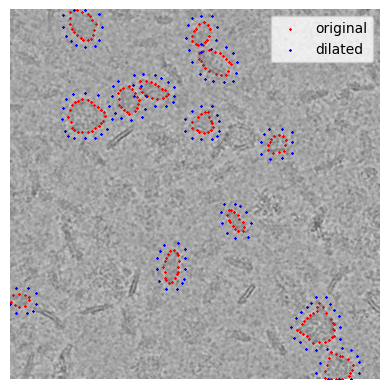

In [119]:
# # Plot the preprocessed image...
# plt.imshow(preprocessed_micrograph, cmap="Greys_r")
# plt.show()
# ...with pick locations overlaid for comparison
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "bilateral",
                                                           d = 11,
                                                           sigmaColor=71,
                                                           sigmaSpace=71)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
ax1.scatter(pick_indices[1]/4, pick_indices[0]/4, marker='x', color='red', s=1, label='original')
ax1.scatter(dilated_pick_indices[1]/4, dilated_pick_indices[0]/4, marker='x', color='blue', s=1, label='dilated')
plt.legend()
plt.axis('off')
plt.show()

# Export pick locations to CryoSPARC

In [ ]:
# Adjust the pick values to reflect initial upsampling of image
pick_indices = postprocess.generate_picks(filtered_masks,
                                          downsample_factor=8,
                                          box_size=16, 
                                          mode="edge")

In [ ]:
# Use the csparc_export module to construct a dataset for export back to cryosparc
pick_dataset = csparc_export.construct_csparc_dataset(micrograph, pick_indices)

In [ ]:
pick_dataset

In [ ]:
# Send the dataset back to cryosparc
csparc_export.export_to_csparc(cs, pick_dataset, "P65", "W15")

In [ ]:
# Initialize project and job
project = cs.find_project("P65")

print("Sending interior picks...")
job1 = project.create_external_job("W15", title="Interior Vesicle Picks")
# Tell the job what kind of output to expect
job1.add_output("particle", "vesicle_picks", slots=["location"])

# Start the job, push the output to cryosparc, stop the job
job1.start()
job1.save_output("vesicle_picks", pick_dataset)
job1.stop()

In [ ]:
# Generate some 2D classes for JLR.

project = cs.find_project("P179")
job = cs.find_job("P179", "J2058")
templates_selected = job.load_output("templates_selected", slots=["blob"])

In [ ]:
unique_mrc_paths = set(templates_selected["blob/path"])
all_templates_blobs = {path: project.download_mrc(path)[1] for path in unique_mrc_paths}

In [ ]:
all_templates_blobs

In [ ]:
%matplotlib inline
N = templates_selected["blob/shape"][0][0]
scale = 100/templates_selected["blob/psize_A"][0]
fig, axes = plt.subplots(3, 5, figsize(5,3), dpi=400)
plt.margins(x=0,y=0)

for i, template in ennumerate(templates_selected.rows()):
    path = template["blob/path"]
    index = template["blob/idx"]
    blob = all_templates_blobs[path][index]
    ax = axes[i // 5, i % 5]
    ax.axis("off")

In [ ]:
row = templates_selected.rows()[0]